## Part 2B - Benchmark: ARPU vs ratio metric + linearization
This notebook compares three approaches on the same user-level aggregates:

ARPU (mean revenue per user)
Ratio metric: revenue per session (group-level ratio)
Linearization for ratio metrics (user-level transformation + t-test)
We evaluate:

effect estimates
confidence intervals
p-values
empirical power / type I error via repeated simulations

In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

repo_root = Path('..').resolve()
src_path = (repo_root / 'src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

#from tecore.simulate import SyntheticB2CConfig, generate_user_level_data, make_default_scenarios

ALPHA = 0.05
RNG = np.random.default_rng(123)

## 1) Load synthetic scenarios (or regenerate)
If you already ran notebook 04, we load CSV files. If not, we regenerate them on the fly.

In [3]:

data_dir = repo_root / 'data' / 'synthetic'
scenario_files = {
    'scenario_monetization': data_dir / 'scenario_monetization.csv',
    'scenario_activity': data_dir / 'scenario_activity.csv',
    'scenario_mixed': data_dir / 'scenario_mixed.csv',
}

frames = {}
all_exist = all(p.exists() for p in scenario_files.values())

if all_exist:
    for name, p in scenario_files.items():
        frames[name] = pd.read_csv(p)
else:
    scenarios = make_default_scenarios(SyntheticB2CConfig(n_users=80_000, seed=42))
    for name, cfg in scenarios.items():
        frames[name] = generate_user_level_data(cfg)

list(frames.keys()), all_exist

(['scenario_monetization', 'scenario_activity', 'scenario_mixed'], False)

2) Helper functions
We implement three tests:

ARPU: two-sample t-test on revenue per user
Ratio: group-level ratio difference + bootstrap CI/p-value
Linearization: user-level z = revenue - R0 * sessions and t-test on z
Notes:

Linearization uses R0 computed on the control group.
For reporting, we convert linearized mean difference into ratio units.

In [4]:
def split_groups(df: pd.DataFrame):
    c = df[df['group'] == 'control'].copy()
    t = df[df['group'] == 'test'].copy()
    return c, t


def arpu_test(df: pd.DataFrame, alpha: float = ALPHA):
    c, t = split_groups(df)
    y_c, y_t = c['revenue'].to_numpy(), t['revenue'].to_numpy()

    # Welch t-test (robust to unequal variances)
    stat, pval = stats.ttest_ind(y_t, y_c, equal_var=False)

    eff = float(y_t.mean() - y_c.mean())
    se = float(np.sqrt(y_t.var(ddof=1)/len(y_t) + y_c.var(ddof=1)/len(y_c)))
    z = stats.norm.ppf(1 - alpha/2)
    ci = (eff - z*se, eff + z*se)

    return {
        'metric': 'ARPU',
        'effect': eff,
        'ci_low': ci[0],
        'ci_high': ci[1],
        'p_value': float(pval),
    }


def ratio_point(df: pd.DataFrame) -> float:
    return float(df['revenue'].sum() / df['sessions'].sum())


def ratio_bootstrap_test(df: pd.DataFrame, n_boot: int = 2000, alpha: float = ALPHA, seed: int = 0):
    c, t = split_groups(df)

    r_c = ratio_point(c)
    r_t = ratio_point(t)
    eff = r_t - r_c

    rng = np.random.default_rng(seed)
    c_idx = np.arange(len(c))
    t_idx = np.arange(len(t))

    boot = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        bc = c.iloc[rng.choice(c_idx, size=len(c), replace=True)]
        bt = t.iloc[rng.choice(t_idx, size=len(t), replace=True)]
        boot[i] = ratio_point(bt) - ratio_point(bc)

    lo = float(np.quantile(boot, alpha/2))
    hi = float(np.quantile(boot, 1 - alpha/2))

    # Two-sided p-value by bootstrap sign test around 0
    pval = float(2 * min((boot <= 0).mean(), (boot >= 0).mean()))

    return {
        'metric': 'Ratio bootstrap',
        'effect': float(eff),
        'ci_low': lo,
        'ci_high': hi,
        'p_value': pval,
    }


def linearization_test(df: pd.DataFrame, alpha: float = ALPHA):
    c, t = split_groups(df)

    # Baseline ratio from control
    R0 = ratio_point(c)

    z_c = c['revenue'].to_numpy() - R0 * c['sessions'].to_numpy()
    z_t = t['revenue'].to_numpy() - R0 * t['sessions'].to_numpy()

    stat, pval = stats.ttest_ind(z_t, z_c, equal_var=False)

    # Convert mean difference in z to ratio units
    mean_sessions_c = float(c['sessions'].mean())
    dz = float(z_t.mean() - z_c.mean())
    eff = dz / mean_sessions_c

    # CI from normal approximation on dz
    se_dz = float(np.sqrt(z_t.var(ddof=1)/len(z_t) + z_c.var(ddof=1)/len(z_c)))
    zcrit = stats.norm.ppf(1 - alpha/2)
    ci = ((dz - zcrit*se_dz)/mean_sessions_c, (dz + zcrit*se_dz)/mean_sessions_c)

    return {
        'metric': 'Ratio linearization',
        'effect': eff,
        'ci_low': float(ci[0]),
        'ci_high': float(ci[1]),
        'p_value': float(pval),
    }

## 3) One-run comparison for each scenario

In [5]:
def run_all_methods(df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
    rows = []
    rows.append(arpu_test(df))
    rows.append(ratio_bootstrap_test(df, n_boot=1200, seed=seed))
    rows.append(linearization_test(df))
    return pd.DataFrame(rows)

for name, df in frames.items():
    print('\n', '='*80)
    print(name)
    display(run_all_methods(df, seed=123))


scenario_monetization

scenario_activity

scenario_mixed


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.003810,-0.302092,0.294472,0.980026
1,Ratio bootstrap,0.006606,-0.081396,0.088903,0.856667
2,Ratio linearization,0.006574,-0.081912,0.095060,0.884227


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.078542,-0.377882,0.220798,0.607069
1,Ratio bootstrap,-0.072290,-0.159602,0.009502,0.091667
2,Ratio linearization,-0.074528,-0.163300,0.014244,0.099876


,metric,effect,ci_low,ci_high,p_value
0,ARPU,-0.079798,-0.377035,0.217439,0.598761
1,Ratio bootstrap,-0.025472,-0.112889,0.057120,0.558333
2,Ratio linearization,-0.025481,-0.113645,0.062683,0.571080


## 4) Empirical power and type I error via repeated simulations
We generate many synthetic datasets and measure how often each method rejects H0 at alpha = 0.05.

Two regimes:

effect datasets: effect is present (power)
null datasets: effect is absent (type I error)

In [9]:
def rejection_rate(method_fn, cfg: SyntheticB2CConfig, n_iter: int, alpha: float, seed0: int) -> float:
    rej = 0
    for i in range(n_iter):
        cfg_i = SyntheticB2CConfig(**{**cfg.__dict__, 'seed': seed0 + i})
        df = generate_user_level_data(cfg_i)
        res = method_fn(df)
        if res['p_value'] < alpha:
            rej += 1
    return rej / n_iter


def make_cfg(effect_type: str, lift_sessions: float, lift_revps: float, seed: int, n_users: int = 60_000):
    return SyntheticB2CConfig(
        n_users=n_users,
        seed=seed,
        effect_type=effect_type,
        lift_sessions=lift_sessions,
        lift_rev_per_session=lift_revps,
        sessions_mean_pre=3.0,
        sessions_mean_post=3.2,
        sessions_dispersion=1.6,
        high_spender_share=0.03,
        revps_lognorm_mu=-0.2,
        revps_lognorm_sigma=1.0,
        high_revps_multiplier=6.0,
        activity_latent_sigma=0.6,
        monetization_latent_sigma=0.7,
        include_binary=False,
    )

methods = {
    'ARPU': arpu_test,
    'Ratio bootstrap': lambda d: ratio_bootstrap_test(d, n_boot=600, seed=1),
    'Ratio linearization': linearization_test,
}

scenarios_cfg = {
    'monetization': make_cfg('monetization', lift_sessions=0.0, lift_revps=0.05, seed=10),
    'activity': make_cfg('activity', lift_sessions=0.07, lift_revps=0.0, seed=20),
    'mixed': make_cfg('mixed', lift_sessions=0.03, lift_revps=0.03, seed=30),
}

null_cfg = make_cfg('none', lift_sessions=0.0, lift_revps=0.0, seed=999)

N_ITER = 200

type1_map = {}
for mname, mfn in methods.items():
    type1_map[mname] = rejection_rate(
        mfn,
        null_cfg,
        n_iter=N_ITER,
        alpha=ALPHA,
        seed0=2000,
    )

# 2) Power per scenario + method
rows = []
for scen_name, cfg in scenarios_cfg.items():
    for mname, mfn in methods.items():
        power = rejection_rate(
            mfn,
            cfg,
            n_iter=N_ITER,
            alpha=ALPHA,
            seed0=1000,
        )
        rows.append(
            {
                "scenario": scen_name,
                "method": mname,
                "power": power,
                "type1_error": type1_map[mname],
            }
        )

summary = pd.DataFrame(rows)
summary

,scenario,method,power,type1_error
0,monetization,ARPU,0.350,0.03
1,monetization,Ratio bootstrap,0.380,0.03
2,monetization,Ratio linearization,0.375,0.03
3,activity,ARPU,0.195,0.03
4,activity,Ratio bootstrap,0.060,0.03
5,activity,Ratio linearization,0.060,0.03
6,mixed,ARPU,0.190,0.03
7,mixed,Ratio bootstrap,0.150,0.03
8,mixed,Ratio linearization,0.160,0.03


## 5) Visualize benchmark results.

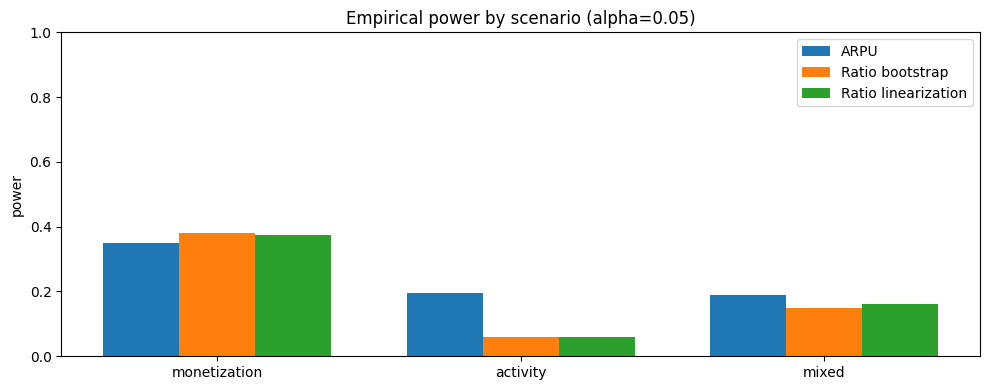

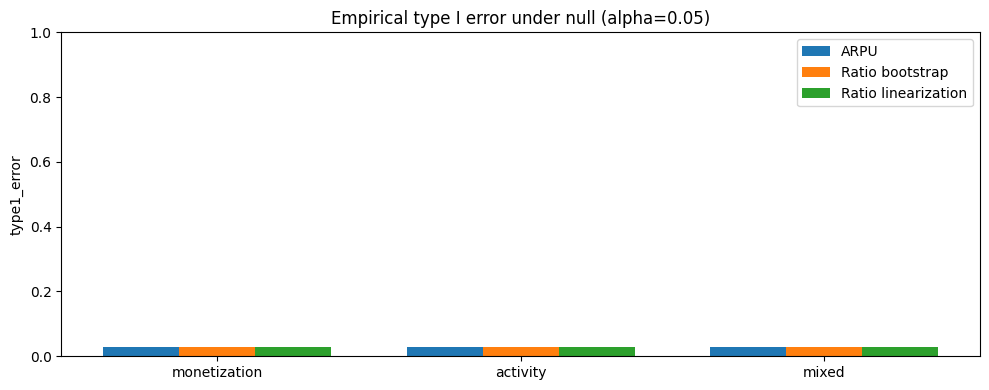

In [10]:
def plot_bars(df: pd.DataFrame, value_col: str, title: str):
    scenarios = df['scenario'].unique().tolist()
    methods = df['method'].unique().tolist()

    x = np.arange(len(scenarios))
    width = 0.25

    plt.figure(figsize=(10, 4))
    for i, m in enumerate(methods):
        vals = [float(df[(df['scenario'] == s) & (df['method'] == m)][value_col].iloc[0]) for s in scenarios]
        plt.bar(x + (i - 1) * width, vals, width=width, label=m)

    plt.xticks(x, scenarios)
    plt.ylim(0, 1)
    plt.ylabel(value_col)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_bars(summary, 'power', 'Empirical power by scenario (alpha=0.05)')
plot_bars(summary, 'type1_error', 'Empirical type I error under null (alpha=0.05)')

## Results summary
- Different effect mechanisms favor different primary metrics.
- Ratio metric with linearization is often more aligned with monetization-only effects.
- Bootstrap ratio test is robust but more computationally expensive.
- Under the null, type I error should be close to alpha.